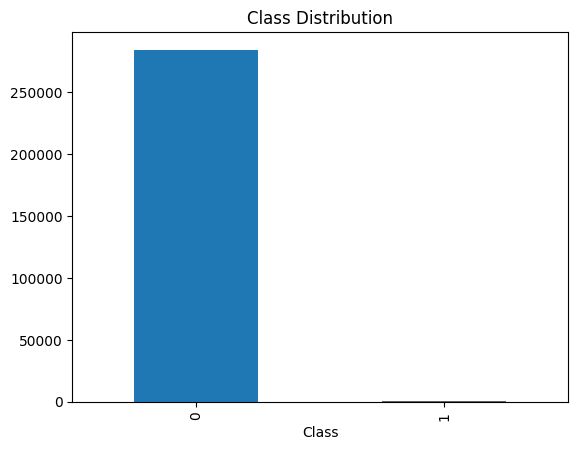

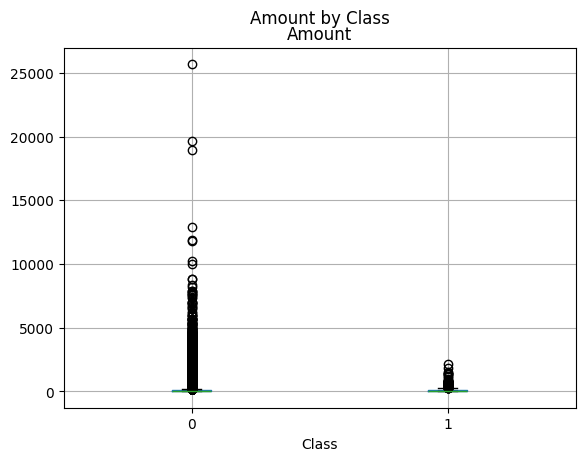

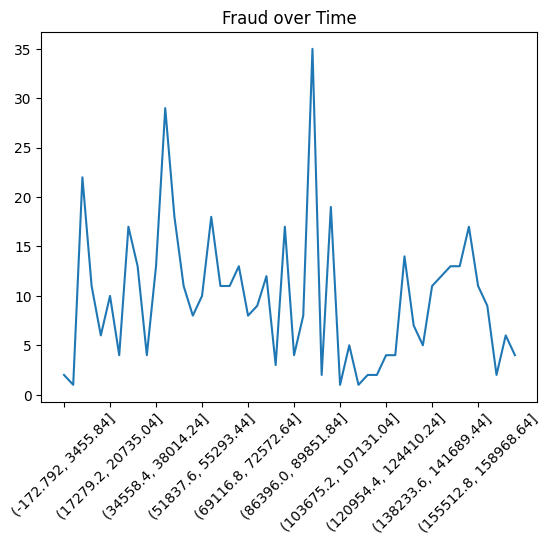

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
# Fraud detection pipeline using SVMs
# Expects dataset file_path = "creditcard.csv"

import os
import sys
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

try:
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.svm import SVC, LinearSVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.metrics import classification_report, roc_auc_score, recall_score
    from imblearn.over_sampling import SMOTE
    import joblib
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 
                           'numpy', 'pandas', 'matplotlib', 
                           'scikit-learn', 'imbalanced-learn', 'joblib'])
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.svm import SVC, LinearSVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.metrics import classification_report, roc_auc_score, recall_score
    from imblearn.over_sampling import SMOTE
    import joblib

# -----------------------------
# Config
# -----------------------------
file_path = "creditcard.csv"
OUTPUT_DIR = "fraud_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PROCESSED_OUT = os.path.join(OUTPUT_DIR, "creditcard_processed.csv")
MODEL_OUT = os.path.join(OUTPUT_DIR, "svm_fraud_detector.joblib")
INSIGHTS_OUT = os.path.join(OUTPUT_DIR, "insights.txt")

if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at {file_path}")

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv(file_path)

features = [c for c in df.columns if c not in ('Class',)]
X = df[features].copy()
y = df['Class'].copy()

scaler_time_amount = StandardScaler()
X[['Time','Amount']] = scaler_time_amount.fit_transform(X[['Time','Amount']])

df_processed = pd.concat([X, y], axis=1)
df_processed.to_csv(PROCESSED_OUT, index=False)

# -----------------------------
# Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# SMOTE (fix: removed n_jobs)
smote = SMOTE(sampling_strategy=0.05, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# -----------------------------
# EDA Visualizations (show inline, not saved)
# -----------------------------
# Class Distribution
ax = y.value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Amount by Class
df.boxplot(column='Amount', by='Class')
plt.suptitle('Amount by Class')
plt.show()

# Fraud over Time
time_bins = pd.cut(df['Time'], bins=50)
time_pattern = df.groupby(time_bins)['Class'].sum()
plt.plot(time_pattern.index.astype(str), time_pattern.values)
plt.xticks(range(0, 50, 5))
plt.xticks(rotation=45)
plt.title("Fraud over Time")
plt.show()

# -----------------------------
# Model Building
# -----------------------------
pipe_rbf = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(probability=True, class_weight='balanced'))
])
pipe_linear = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', CalibratedClassifierCV(
        estimator=LinearSVC(class_weight='balanced', max_iter=10000), cv=3))
])

param_grid_rbf = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf'],
    'svc__gamma': ['scale', 'auto']
}
param_grid_linear = {
    'svc__estimator__C': [0.01, 0.1, 1, 10]
}

gs_rbf = GridSearchCV(pipe_rbf, param_grid_rbf, scoring='recall', cv=3, n_jobs=-1, verbose=1)
gs_linear = GridSearchCV(pipe_linear, param_grid_linear, scoring='recall', cv=3, n_jobs=-1, verbose=1)

gs_rbf.fit(X_res, y_res)
gs_linear.fit(X_res, y_res)

best_rbf = gs_rbf.best_estimator_
best_linear = gs_linear.best_estimator_

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    print(f"--- Evaluation: {name} ---")
    print(classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.4f}")

evaluate_model(best_rbf, X_test, y_test, 'RBF SVM')
evaluate_model(best_linear, X_test, y_test, 'Linear SVM')

rbf_rec = recall_score(y_test, best_rbf.predict(X_test))
lin_rec = recall_score(y_test, best_linear.predict(X_test))
model = best_rbf if rbf_rec >= lin_rec else best_linear
print(f"Selected model: {'RBF' if model is best_rbf else 'Linear'} with recall {max(rbf_rec, lin_rec):.4f}")

# -----------------------------
# Streaming Simulation
# -----------------------------
def stream_and_alert(model, source_path, chunk_size=5000):
    reader = pd.read_csv(source_path, chunksize=chunk_size)
    alert_count = 0
    for chunk in reader:
        features_chunk = chunk[[c for c in chunk.columns if c != 'Class']].copy()
        features_chunk[['Time','Amount']] = scaler_time_amount.transform(features_chunk[['Time','Amount']])
        preds = model.predict(features_chunk)
        frauds = chunk[preds == 1]
        for _, row in frauds.iterrows():
            alert_count += 1
            print(f"ALERT #{alert_count}: Potential fraud. Transaction index={row.name}, Amount={row['Amount']}")
    print(f"Streaming complete. Total alerts: {alert_count}")

sample_sim = df.sample(n=20000, random_state=42)
sample_path = os.path.join(OUTPUT_DIR, "stream_sample.csv")
sample_sim.to_csv(sample_path, index=False)
stream_and_alert(model, sample_path, chunk_size=2000)

# -----------------------------
# Insights
# -----------------------------
insights = []
fraud_times = df[df['Class'] == 1]['Time']
if len(fraud_times) > 0:
    peak_bin = pd.cut(fraud_times, bins=6).value_counts().idxmax()
    insights.append(f"Frauds concentrated in time bin: {peak_bin}")
fraud_amounts = df[df['Class'] == 1]['Amount']
if len(fraud_amounts) > 0:
    insights.append(f"Median fraud amount: {fraud_amounts.median():.2f}, mean: {fraud_amounts.mean():.2f}")
insights.append("Recommend: real-time scoring, velocity checks, block or challenge transactions from suspicious IPs, 2FA for high-value transactions")

with open(INSIGHTS_OUT, 'w') as f:
    f.write('\n'.join(insights))

# -----------------------------
# Save Model
# -----------------------------
joblib.dump(model, MODEL_OUT)
print(f"Model saved to {MODEL_OUT}")
print(f"Processed dataset saved to {PROCESSED_OUT}")
print(f"Insights saved to {INSIGHTS_OUT}")
